/data/vinay_2421ma05/VINAY/BS_PF/.conda/bin/python
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])


/tmp/ipykernel_254376/855293107.py:42: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


FLS(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SinAct()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Tanh()
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
)
No of Parameters 264193


  0%|          | 0/600 [00:00<?, ?it/s]/data/vinay_2421ma05/VINAY/BS_PF/.conda/lib/python3.12/site-packages/torch/autograd/graph.py:825: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at ../aten/src/ATen/cuda/CublasHandlePool.cpp:135.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
  0%|          | 1/600 [00:00<06:06,  1.63it/s]

0/600 PDE Loss: 0.000844579, BVP Loss: 0.001903123, IC Loss: 0.000871473,


 17%|█▋        | 101/600 [01:43<12:00,  1.44s/it]

100/600 PDE Loss: 0.000003920, BVP Loss: 0.000008587, IC Loss: 0.000000208,


 34%|███▎      | 202/600 [02:04<00:32, 12.31it/s]

200/600 PDE Loss: 0.000003667, BVP Loss: 0.000007748, IC Loss: 0.000000156,


 50%|█████     | 302/600 [02:12<00:24, 12.41it/s]

300/600 PDE Loss: 0.000003667, BVP Loss: 0.000007748, IC Loss: 0.000000156,


 67%|██████▋   | 402/600 [02:20<00:16, 12.04it/s]

400/600 PDE Loss: 0.000003667, BVP Loss: 0.000007748, IC Loss: 0.000000156,


 84%|████████▎ | 502/600 [02:28<00:08, 11.98it/s]

500/600 PDE Loss: 0.000003667, BVP Loss: 0.000007748, IC Loss: 0.000000156,


100%|██████████| 600/600 [02:36<00:00,  3.83it/s]


Loss Res:  0.000004, Loss_BC:  0.000008, Loss_IC:  0.000000
Train Loss: 0.000012


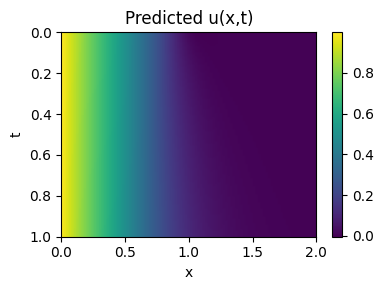

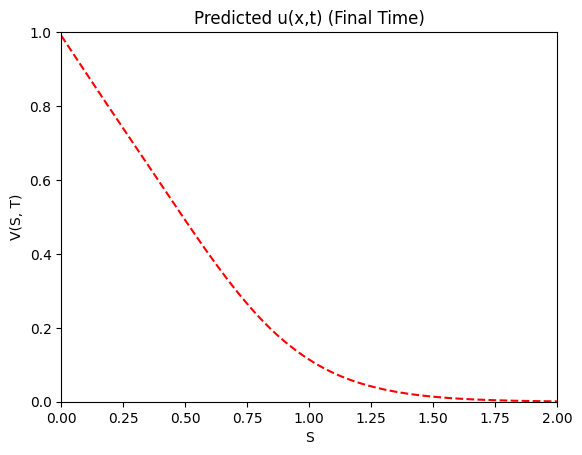

In [1]:
import sys
from zmq import device
print(sys.executable)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
from scipy.stats import norm
from utils import *
from pinn import PINNs
from fls import FLS

K=1
sigma=0.3
r=0.01
T=1
L=2
N_x = 101
N_t = 101
seed = 0
torch.cuda.manual_seed(seed)
device = torch.device("cuda:0")
res, b_left, b_right, b_upper, b_lower = get_data([0,2], [0, 1], N_x, N_t)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]
print(x_res.shape, x_left.shape, x_right.shape, x_upper.shape, x_lower.shape)
print(t_res.shape, t_left.shape, t_right.shape, t_upper.shape, t_lower.shape)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
pinn = FLS(in_dim=2, hidden_dim=256, out_dim=1, num_layer=6).to(device)
pinn.apply(init_weights)
optim = LBFGS(pinn.parameters(), line_search_fn='strong_wolfe')
#optim = Adam(pinn.parameters(), lr=1e-4)
n_params = get_n_params(pinn)
print(pinn)
print('No of Parameters',n_params)
loss_track = []
n_epochs = 600
for i in tqdm(range(n_epochs)):
  def closure():
    pred_res = pinn(x_res, t_res)
    pred_left = pinn(x_left, t_left)
    pred_right = pinn(x_right, t_right)
    pred_upper = pinn(x_upper, t_upper)
    pred_lower = pinn(x_lower, t_lower)
    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    loss_res = torch.mean((u_t - ((sigma**2 * x_res**2) / 2) * u_xx - (r * x_res) * u_x + (r * pred_res)) ** 2)
    loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower - (K * torch.exp(-r * t_lower))) ** 2)
    loss_ic = torch.mean((pred_left[:,0] - torch.max(K - x_left[:,0], torch.zeros(x_left[:,0].shape).to(device))) ** 2)
    loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    loss = loss_res + loss_ic + loss_bc
    optim.zero_grad()
    loss.backward()
    return loss
  optim.step(closure)
  if i % 100 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {loss_track[-1][0]:.9f}, BVP Loss: {loss_track[-1][1]:.9f}, IC Loss: {loss_track[-1][2]:.9f},')

print('Loss Res: {:9f}, Loss_BC: {:9f}, Loss_IC: {:9f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

state = {
    'epoch': n_epochs,
    'state_dict': pinn.state_dict(),
    'optimizer': optim.state_dict(),
    'loss_hist': loss_track
}
torch.save(state, './BS_Put_PINNs_101')

# Testing
N_x=101
N_t=101
res_test, _, b_right_test, _, _ = get_test_data([0,L], [0,1], N_x, N_t)
N = norm.cdf
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
b_right_test = torch.tensor(b_right_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]
x_right_test, t_right_test = b_right_test[:,0:1], b_right_test[:,1:2]
x_test.requires_grad_()
t_test.requires_grad_()

#with torch.no_grad():
pred = pinn(x_test, t_test)[:,0:1]
pred_right = pinn(x_right_test, t_right_test)[:,0:1]
    #pred = pred.cpu().detach().numpy()
pred_right = pred_right.cpu().detach().numpy()
#pred = pred.reshape(N_x,N_t)
# print(pred_right.shape)

delta=torch.autograd.grad(pred, x_test, grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0]
gamma=torch.autograd.grad(delta,x_test,grad_outputs=torch.ones_like(delta), retain_graph=True, create_graph=True)[0]
theta=torch.autograd.grad(pred,t_test,grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0]


#convert prediction to numpy for plotting
pred_np = pred.cpu().detach().numpy()
pred_np = pred_np.reshape(N_x, N_t)
def BS_CALL(S, T):
    d1 = (torch.log(S/K) + (r + sigma**2 / 2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    return S * N(d1) - K * torch.exp(-r*T)* N(d2)

def BS_PUT(S, T):
    d1 = (np.log(np.where(S/K > 1e-8, S/K, 1e-8)) + (r + sigma**2/2)*T) / (sigma*np.sqrt(np.where(T > 1e-8, T, 1e-8)))
    d2 = d1 - sigma* np.sqrt(T)
    return K * np.exp(-r*T) * (1 - N(d2)) + S * (N(d1) - 1)



plt.figure(figsize=(4,3))
plt.imshow(pred_np, extent=[0,L,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dBS_Put_pinns_pred.png')
plt.show()


# plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")
plt.figure()
plt.plot(x_right_test.cpu().detach().numpy(), pred_right, '--', color="r")
plt.xlabel('S')
plt.ylabel('V(S, T)')
plt.title('Predicted u(x,t) (Final Time)')
# set the limits
plt.xlim([0, L])
plt.ylim([0, 1])
plt.savefig('./1dBS_Put_pinns_pred(Final Time).png')
plt.show()


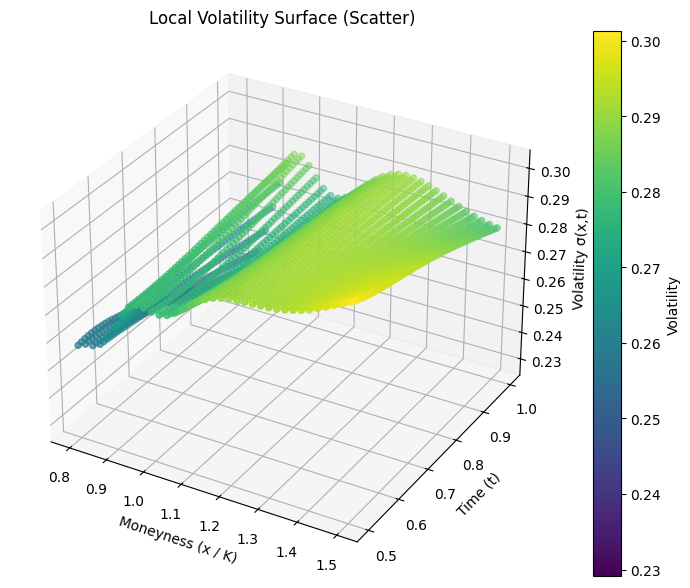

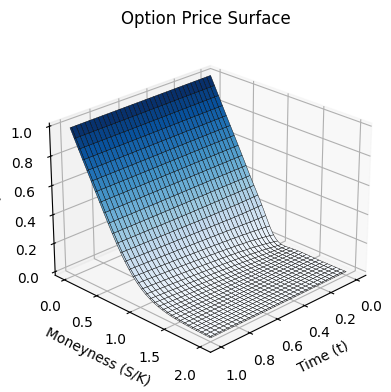

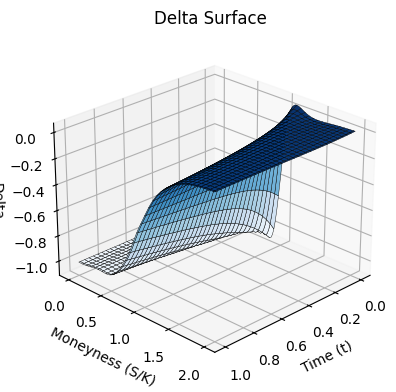

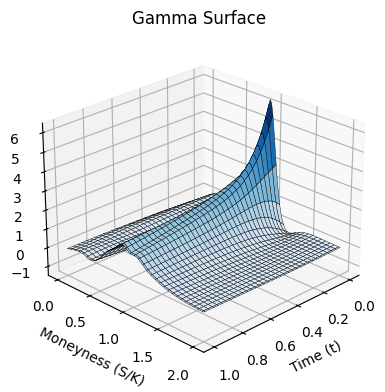

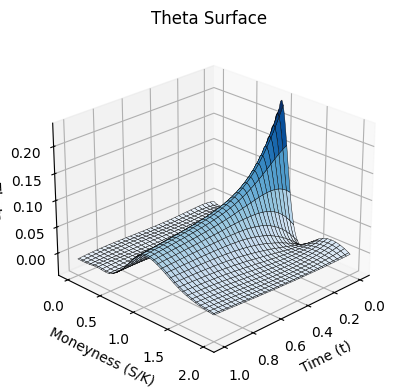

In [4]:
# computing the volatility surface 
vol_sur= 2*((theta+r*x_test*delta)/(x_test**2*gamma))
vol_sur=torch.sqrt(vol_sur)
vol_sur_np=vol_sur.cpu().detach().numpy().reshape(N_x, N_t)
vol_sur_np = vol_sur.cpu().detach().numpy().flatten()
t_np = t_test.cpu().detach().numpy().flatten()
moneyness = (x_test / K).cpu().detach().numpy().flatten()
mask = (moneyness >= 0.8) & (moneyness <= 1.5)
filtered_moneyness = moneyness[mask]
filtered_t = t_np[mask]
filtered_vol = vol_sur_np[mask]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Step 1: Compute volatility surface
vol_sur = 2 * ((theta + r * x_test * delta) / (x_test**2 * gamma))
#vol_sur = torch.clamp(vol_sur, min=1e-8)
vol_sur = torch.sqrt(vol_sur)

# Step 2: Convert to numpy
vol_sur_np = vol_sur.cpu().detach().numpy().flatten()
t_np = t_test.cpu().detach().numpy().flatten()
moneyness = (x_test / K).cpu().detach().numpy().flatten()

# Step 3: Filter the region: moneyness in [0.8, 1.5], time in [0.5, 1]
mask = (moneyness >= 0.8) & (moneyness <= 1.5) & (t_np >= 0.5) & (t_np <= 1.0)
filtered_moneyness = moneyness[mask]
filtered_t = t_np[mask]
filtered_vol = vol_sur_np[mask]

# Step 4: Plot 3D scatter
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(filtered_moneyness, filtered_t, filtered_vol,
                c=filtered_vol, cmap='viridis', marker='o')

ax.set_xlabel('Moneyness (x / K)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Volatility σ(x,t)')
ax.set_title('Local Volatility Surface (Scatter)')
fig.colorbar(sc, label='Volatility')
plt.tight_layout()
plt.savefig('vol_surface_scatter.png')
plt.show()



# Step 1: Convert to NumPy
delta_np = delta.cpu().detach().numpy().reshape(N_x, N_t)
gamma_np = gamma.cpu().detach().numpy().reshape(N_x, N_t)
theta_np= theta.cpu().detach().numpy().reshape(N_x, N_t)
t_np = t_test.cpu().detach().numpy().reshape(N_x, N_t)
moneyness = (x_test / K).cpu().detach().numpy().reshape(N_x, N_t)

def plot_surf(t_grid, moneyness_grid, Z, zlabel, title, filename):
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    # Now t is x-axis, moneyness is y-axis
    ax.plot_surface(t_grid, moneyness_grid, Z, cmap='Blues', edgecolor='k', linewidth=0.3)
    
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Moneyness (S/K)')
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    

    ax.view_init(elev=25, azim=45)
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_surf(t_np, moneyness, pred_np, 'Price', 'Option Price Surface', './price_surface.png')
plot_surf(t_np, moneyness, delta_np, 'Delta', 'Delta Surface', './delta_surface.png')
plot_surf(t_np, moneyness, gamma_np, 'Gamma', 'Gamma Surface', './gamma_surface.png')
plot_surf(t_np, moneyness, theta_np, 'Theta', 'Theta Surface', './theta_surface.png')

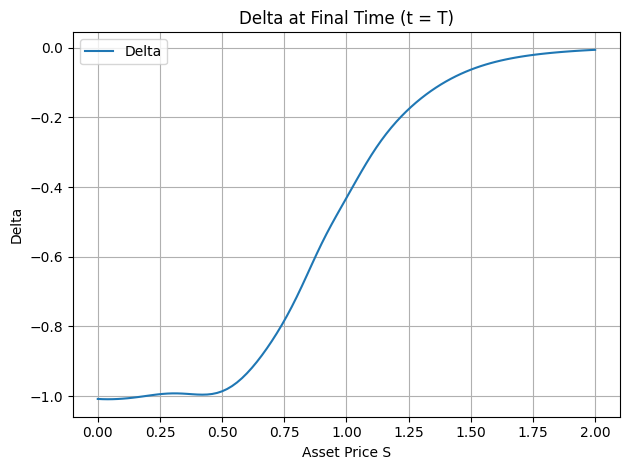

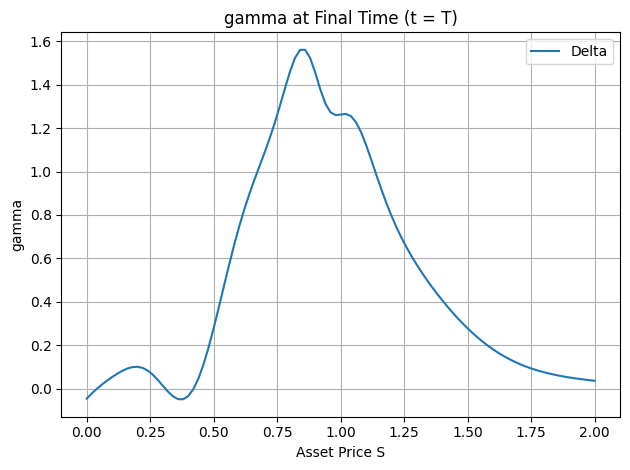

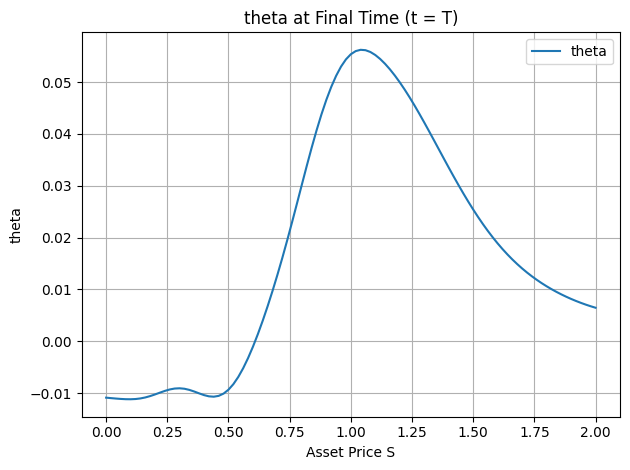

In [3]:
# Final time index
final_index = (N_t - 1)
# Extract the delta at final time
x_plot = x_test[final_index * N_x : (final_index + 1) * N_x].cpu().detach().numpy()
delta_plot = delta[final_index * N_x : (final_index + 1) * N_x].cpu().detach().numpy()
gamma_plot = gamma[final_index * N_x : (final_index + 1) * N_x].cpu().detach().numpy()
theta_plot = theta[final_index * N_x : (final_index + 1) * N_x].cpu().detach().numpy()
# Plot
plt.figure()
plt.plot(x_plot, delta_plot, label='Delta')
plt.xlabel('Asset Price S')
plt.ylabel('Delta')
plt.title('Delta at Final Time (t = T)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./1dBS_Put_delta_final_time_plot.png')
plt.show()

plt.figure()
plt.plot(x_plot, gamma_plot, label='Delta')
plt.xlabel('Asset Price S')
plt.ylabel('gamma')
plt.title('gamma at Final Time (t = T)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./1dBS_Put_gamma_final_time_plot.png')
plt.show()

plt.figure()
plt.plot(x_plot, theta_plot, label='theta')
plt.xlabel('Asset Price S')
plt.ylabel('theta')
plt.title('theta at Final Time (t = T)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('./1dBS_Put_theta_final_time_plot.png')
plt.show()


VOLATILITY SURFACE WITH ADAM+LBFGS OPTIMISERS 

/tmp/ipykernel_254376/467749373.py:42: FutureWarning: `nn.init.xavier_uniform` is now deprecated in favor of `nn.init.xavier_uniform_`.
  torch.nn.init.xavier_uniform(m.weight)


/data/vinay_2421ma05/VINAY/BS_PF/.conda/bin/python
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])
torch.Size([10000, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1]) torch.Size([101, 1])
FLS(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=256, bias=True)
    (1): SinAct()
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): Tanh()
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): Tanh()
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): Tanh()
    (8): Linear(in_features=256, out_features=256, bias=True)
    (9): Tanh()
    (10): Linear(in_features=256, out_features=1, bias=True)
  )
)
No of Parameters 264193


  5%|▌         | 5/100 [00:00<00:02, 47.16it/s]

0/100 PDE Loss: 0.013256021, BVP Loss: 0.181041896, IC Loss: 1.126904368,


  0%|          | 1/500 [00:00<02:32,  3.27it/s]

100/100 PDE Loss: 0.000235365, BVP Loss: 0.001601985, IC Loss: 0.000202137,


 20%|██        | 101/500 [00:45<03:02,  2.19it/s]

200/100 PDE Loss: 0.000004952, BVP Loss: 0.000015204, IC Loss: 0.000000304,


 42%|████▏     | 210/500 [00:56<00:05, 48.72it/s]

300/100 PDE Loss: 0.000004219, BVP Loss: 0.000009952, IC Loss: 0.000000242,


 61%|██████▏   | 307/500 [00:58<00:03, 48.46it/s]

400/100 PDE Loss: 0.000004219, BVP Loss: 0.000009952, IC Loss: 0.000000242,


 81%|████████▏ | 407/500 [01:00<00:01, 48.20it/s]

500/100 PDE Loss: 0.000004219, BVP Loss: 0.000009952, IC Loss: 0.000000242,


100%|██████████| 500/500 [01:02<00:00,  7.98it/s]


Loss Res:  0.000004, Loss_BC:  0.000010, Loss_IC:  0.000000
Train Loss: 0.000014


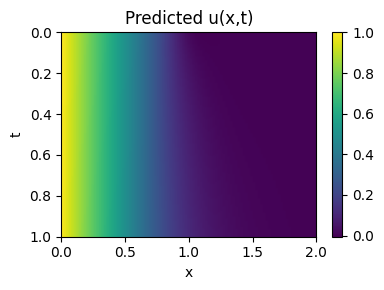

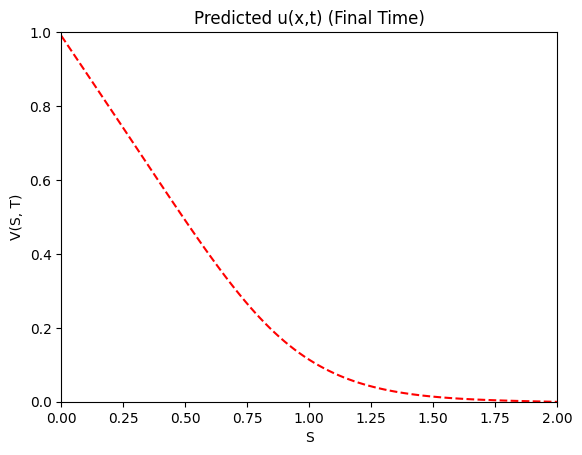

In [5]:
import sys
from zmq import device
print(sys.executable)
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
from scipy.stats import norm
from utils import *
from pinn import PINNs
from fls import FLS

K=1
sigma=0.3
r=0.01
T=1
L=2
N_x = 101
N_t = 101
seed = 0
torch.cuda.manual_seed(seed)
device = torch.device("cuda:0")
res, b_left, b_right, b_upper, b_lower = get_data([0,2], [0, 1], N_x, N_t)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)
x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]
print(x_res.shape, x_left.shape, x_right.shape, x_upper.shape, x_lower.shape)
print(t_res.shape, t_left.shape, t_right.shape, t_upper.shape, t_lower.shape)
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)
pinn = FLS(in_dim=2, hidden_dim=256, out_dim=1, num_layer=6).to(device)
pinn.apply(init_weights)
#optim = LBFGS(pinn.parameters(), line_search_fn='strong_wolfe')
optim = Adam(pinn.parameters(), lr=1e-4)
n_params = get_n_params(pinn)
print(pinn)
print('No of Parameters',n_params)
loss_track = []
n_epochs = 100
for i in tqdm(range(n_epochs)):
  def closure():
    pred_res = pinn(x_res, t_res)
    pred_left = pinn(x_left, t_left)
    pred_right = pinn(x_right, t_right)
    pred_upper = pinn(x_upper, t_upper)
    pred_lower = pinn(x_lower, t_lower)
    u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
    loss_res = torch.mean((u_t - ((sigma**2 * x_res**2) / 2) * u_xx - (r * x_res) * u_x + (r * pred_res)) ** 2)
    loss_bc = torch.mean((pred_upper) ** 2) + torch.mean((pred_lower - (K * torch.exp(-r * t_lower))) ** 2)
    loss_ic = torch.mean((pred_left[:,0] - torch.max(K - x_left[:,0], torch.zeros(x_left[:,0].shape).to(device))) ** 2)
    loss_track.append([loss_res.item(), loss_ic.item(), loss_bc.item()])
    loss = loss_res + loss_ic + loss_bc
    optim.zero_grad()
    loss.backward()
    return loss
  optim.step(closure)
  if i % 100 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {loss_track[-1][0]:.9f}, BVP Loss: {loss_track[-1][1]:.9f}, IC Loss: {loss_track[-1][2]:.9f},')
optim = LBFGS(pinn.parameters(), line_search_fn='strong_wolfe')
for i in tqdm(range(n_epochs, 600)):
    optim.step(closure)
    if i % 100 == 0:
        print(f'{i}/{n_epochs} PDE Loss: {loss_track[-1][0]:.9f}, BVP Loss: {loss_track[-1][1]:.9f}, IC Loss: {loss_track[-1][2]:.9f},')

print('Loss Res: {:9f}, Loss_BC: {:9f}, Loss_IC: {:9f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

state = {
    'epoch': n_epochs,
    'state_dict': pinn.state_dict(),
    'optimizer': optim.state_dict(),
    'loss_hist': loss_track
}
torch.save(state, './BS_Put_PINNs_101')

# Testing
N_x=101
N_t=101
res_test, _, b_right_test, _, _ = get_test_data([0,L], [0,1], N_x, N_t)
N = norm.cdf
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
b_right_test = torch.tensor(b_right_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]
x_right_test, t_right_test = b_right_test[:,0:1], b_right_test[:,1:2]
x_test.requires_grad_()
t_test.requires_grad_()

#with torch.no_grad():
pred = pinn(x_test, t_test)[:,0:1]
pred_right = pinn(x_right_test, t_right_test)[:,0:1]
    #pred = pred.cpu().detach().numpy()
pred_right = pred_right.cpu().detach().numpy()
#pred = pred.reshape(N_x,N_t)
# print(pred_right.shape)

delta=torch.autograd.grad(pred, x_test, grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0]
gamma=torch.autograd.grad(delta,x_test,grad_outputs=torch.ones_like(delta), retain_graph=True, create_graph=True)[0]
theta=torch.autograd.grad(pred,t_test,grad_outputs=torch.ones_like(pred), retain_graph=True, create_graph=True)[0]


#convert prediction to numpy for plotting
pred_np = pred.cpu().detach().numpy()
pred_np = pred_np.reshape(N_x, N_t)
def BS_CALL(S, T):
    d1 = (torch.log(S/K) + (r + sigma**2 / 2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * torch.sqrt(T)
    return S * N(d1) - K * torch.exp(-r*T)* N(d2)

def BS_PUT(S, T):
    d1 = (np.log(np.where(S/K > 1e-8, S/K, 1e-8)) + (r + sigma**2/2)*T) / (sigma*np.sqrt(np.where(T > 1e-8, T, 1e-8)))
    d2 = d1 - sigma* np.sqrt(T)
    return K * np.exp(-r*T) * (1 - N(d2)) + S * (N(d1) - 1)



plt.figure(figsize=(4,3))
plt.imshow(pred_np, extent=[0,L,1,0], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dBS_Put_pinns_pred.png')
plt.show()


# plt.plot(X[final_index, 0], y_pred[final_index], '--', color="r")
plt.figure()
plt.plot(x_right_test.cpu().detach().numpy(), pred_right, '--', color="r")
plt.xlabel('S')
plt.ylabel('V(S, T)')
plt.title('Predicted u(x,t) (Final Time)')
# set the limits
plt.xlim([0, L])
plt.ylim([0, 1])
plt.savefig('./1dBS_Put_pinns_pred(Final Time).png')
plt.show()


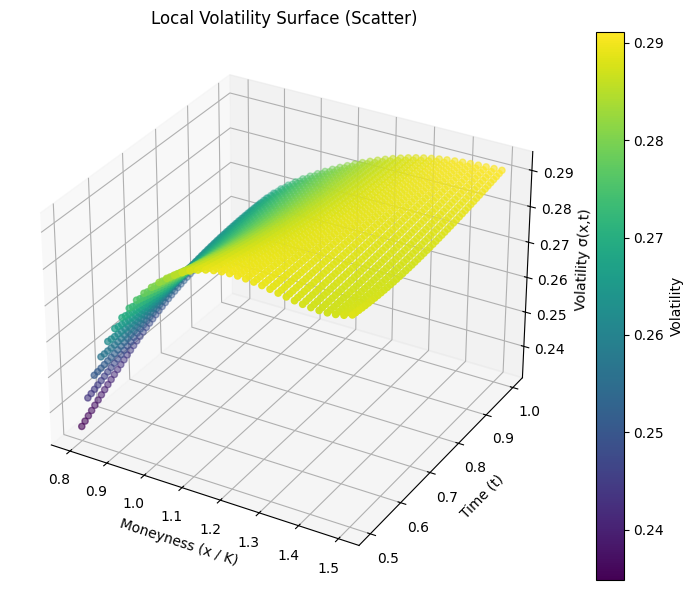

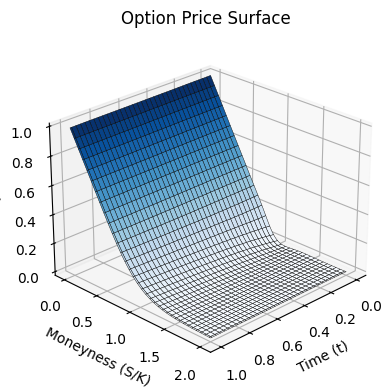

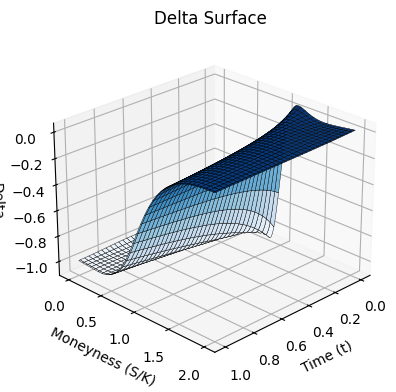

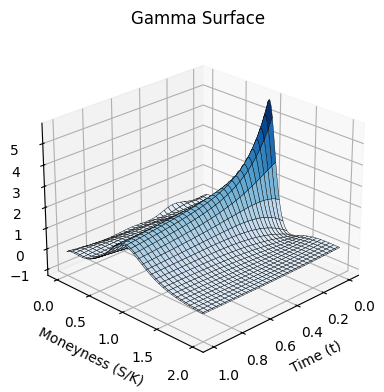

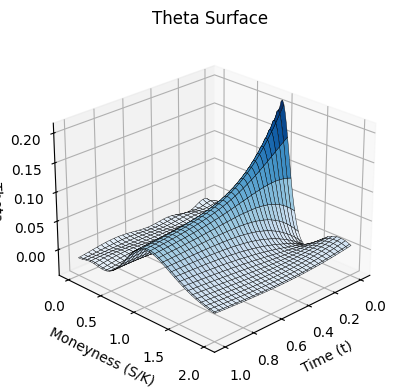

In [8]:
# computing the volatility surface 
vol_sur= 2*((theta+r*x_test*delta)/(x_test**2*gamma))
vol_sur=torch.sqrt(vol_sur)
vol_sur_np=vol_sur.cpu().detach().numpy().reshape(N_x, N_t)
vol_sur_np = vol_sur.cpu().detach().numpy().flatten()
t_np = t_test.cpu().detach().numpy().flatten()
moneyness = (x_test / K).cpu().detach().numpy().flatten()
mask = (moneyness >= 0.8) & (moneyness <= 1.5)
filtered_moneyness = moneyness[mask]
filtered_t = t_np[mask]
filtered_vol = vol_sur_np[mask]

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Step 1: Compute volatility surface
vol_sur = 2 * ((theta + r * x_test * delta) / (x_test**2 * gamma))
#vol_sur = torch.clamp(vol_sur, min=1e-8)
vol_sur = torch.sqrt(vol_sur)

# Step 2: Convert to numpy
vol_sur_np = vol_sur.cpu().detach().numpy().flatten()
t_np = t_test.cpu().detach().numpy().flatten()
moneyness = (x_test / K).cpu().detach().numpy().flatten()

# Step 3: Filter the region: moneyness in [0.8, 1.5], time in [0.5, 1]
mask = (moneyness >= 0.8) & (moneyness <= 1.5) & (t_np >= 0.5) & (t_np <= 1.0)
filtered_moneyness = moneyness[mask]
filtered_t = t_np[mask]
filtered_vol = vol_sur_np[mask]

# Step 4: Plot 3D scatter
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(filtered_moneyness, filtered_t, filtered_vol,
                c=filtered_vol, cmap='viridis', marker='o')

ax.set_xlabel('Moneyness (x / K)')
ax.set_ylabel('Time (t)')
ax.set_zlabel('Volatility σ(x,t)')
ax.set_title('Local Volatility Surface (Scatter)')
fig.colorbar(sc, label='Volatility')
plt.tight_layout()
plt.savefig('vol_surface_scatter.png')
plt.show()



# Step 1: Convert to NumPy
delta_np = delta.cpu().detach().numpy().reshape(N_x, N_t)
gamma_np = gamma.cpu().detach().numpy().reshape(N_x, N_t)
theta_np= theta.cpu().detach().numpy().reshape(N_x, N_t)
t_np = t_test.cpu().detach().numpy().reshape(N_x, N_t)
moneyness = (x_test / K).cpu().detach().numpy().reshape(N_x, N_t)

def plot_surf(t_grid, moneyness_grid, Z, zlabel, title, filename):
    fig = plt.figure(figsize=(5, 4))
    ax = fig.add_subplot(111, projection='3d')
    
    # Now t is x-axis, moneyness is y-axis
    ax.plot_surface(t_grid, moneyness_grid, Z, cmap='Blues', edgecolor='k', linewidth=0.3)
    
    ax.set_xlabel('Time (t)')
    ax.set_ylabel('Moneyness (S/K)')
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    

    ax.view_init(elev=25, azim=45)
    
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

plot_surf(t_np, moneyness, pred_np, 'Price', 'Option Price Surface', './price_surface.png')
plot_surf(t_np, moneyness, delta_np, 'Delta', 'Delta Surface', './delta_surface.png')
plot_surf(t_np, moneyness, gamma_np, 'Gamma', 'Gamma Surface', './gamma_surface.png')
plot_surf(t_np, moneyness, theta_np, 'Theta', 'Theta Surface', './theta_surface.png')